In [2]:
import numpy as np
from scipy.io import netcdf as nc
from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.basemap import Basemap, cm, shiftgrid, maskoceans
from matplotlib import colors
import numpy.ma as ma
from scipy.interpolate import griddata
import copy

In [3]:
nlon = 180
nlat = 90
grid_area = np.ones((nlat, nlon))*-9999.
earth_area =  5.096e14;
lat = np.arange(-89, 91, 2)
res = 2;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

In [41]:
############################################################
### Diagnosis of transient case
############################################################

## Inputs from user
## Some constants
yr_beg = 1850
nyr = 150

##  get and open the history file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
filename_in = 'fates.nor_spinup.elm.h0.1850_2000.nc'

## Do not modify the following
## Spinup history
# Monthly mean output
fin = nc.netcdf_file(filename_in)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years

## define the sizes of each dimension
ntim = len(time)

## read in variables
soilc = fin.variables['SOILC'][:]
vegc = fin.variables['FATES_VEGC_ABOVEGROUND'][:]
litterc = fin.variables['LITTERC'][:]
vegc_pf = fin.variables['FATES_VEGC_PF'][:]
# vegc_age = fin.variables['FATES_VEGC_AP'][:]

# C fluxes
gpp = fin.variables['FATES_GPP'][:]
npp = fin.variables['FATES_NPP'][:]
nep = fin.variables['FATES_NEP'][:]
nbp = fin.variables['NBP'][:]
hr = fin.variables['FATES_HET_RESP'][:]
litc_in = fin.variables['FATES_LITTER_IN'][:]
litc_out = fin.variables['FATES_LITTER_OUT'][:]

fin.close()

# Auxiliary data: land use time series
## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_c_vh1 = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_c_vh2 = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_c_sh1 = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_c_sh2 = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_c_sh3 = fin_luinput2.variables['HARVEST_SH3'][:]
lu_hrv_frac_vh1 = fin_luinput2.variables['HARVEST_VH1_FRAC'][:]
lu_hrv_frac_vh2 = fin_luinput2.variables['HARVEST_VH2_FRAC'][:]
lu_hrv_frac_sh1 = fin_luinput2.variables['HARVEST_SH1_FRAC'][:]
lu_hrv_frac_sh2 = fin_luinput2.variables['HARVEST_SH2_FRAC'][:]
lu_hrv_frac_sh3 = fin_luinput2.variables['HARVEST_SH3_FRAC'][:]
fin_luinput2.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
lat_4x5 = latnc
lon_4x5 = lonnc


In [6]:
# Open some obsered datasets
# Tropical
filename_in = 'biomass_data_ilamb/tropical_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
tropical_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
tropical_for_c = tropical_for_c_tmp[0,:,:]

# ESACCI
filename_in = 'biomass_data_ilamb/esacci_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
esacci_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
esacci_for_c = esacci_for_c_tmp[0,:,:]

# Global Carbon
filename_in = 'biomass_data_ilamb/global_carbon_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
gc_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
gc_for_c = gc_for_c_tmp[0,:,:]

# NBCD2000
filename_in = 'biomass_data_ilamb/nbcd2000_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
nbcd2000_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
nbcd2000_for_c = nbcd2000_for_c_tmp[0,:,:]

# US Forest
filename_in = 'biomass_data_ilamb/US_forest_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
usf_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
usf_for_c = usf_for_c_tmp[0,:,:]

# Thurner
filename_in = 'biomass_data_ilamb/Thurner_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
thurner_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
thurner_for_c = thurner_for_c_tmp[0,:,:]


In [39]:
np.shape(vegc)

(1812, 46, 72)

In [45]:
np.shape(vegc_fates_all)

(46L, 72L)

In [59]:
# Get the latitudinal mean of the forest biomass of all datasets
vegc_pf_copy = copy.deepcopy(vegc_pf)
vegc_pf_copy[vegc_pf_copy>1e2] = np.float('nan')
vegc_pf_copy[vegc_pf_copy<0] = np.float('nan')
vegc_fates = np.nansum(vegc_pf_copy[1811,0:12,:,:], 0)
vegc_fates_for = np.nansum(vegc_pf_copy[1811,0:9,:,:], 0)
vegc_copy = copy.deepcopy(vegc)
vegc_copy[vegc_copy>1e2] = np.float('nan')
vegc_copy[vegc_copy<0] = np.float('nan')
vegc_fates_all = vegc_copy[1811,:,:]
# FATES
vegc_lat = np.nanmean(vegc_fates, 1)
vegc_lat_for = np.nanmean(vegc_fates_for, 1)
vegc_all_lat = np.nanmean(vegc_fates_all, 1)

# Other obs
tropical_for_c_copy = copy.deepcopy(tropical_for_c)
tropical_for_c_copy[tropical_for_c_copy>1e5] = np.float('nan')
esacci_for_c_copy = copy.deepcopy(esacci_for_c)
esacci_for_c_copy[esacci_for_c_copy>1e5] = np.float('nan')
gc_for_c_copy = copy.deepcopy(gc_for_c)
gc_for_c_copy[gc_for_c_copy>1e5] = np.float('nan')
gc_for_c_copy[gc_for_c_copy<0] = np.float('nan')
nbcd2000_for_c_copy = copy.deepcopy(nbcd2000_for_c)
nbcd2000_for_c_copy[nbcd2000_for_c_copy>1e5] = np.float('nan')
usf_for_c_copy = copy.deepcopy(usf_for_c)
usf_for_c_copy[usf_for_c_copy>1e5] = np.float('nan')
thurner_for_c_copy = copy.deepcopy(thurner_for_c)
thurner_for_c_copy[thurner_for_c_copy>1e5] = np.float('nan')

tropical_lat = np.nanmean(tropical_for_c_copy, 1)
esacci_lat = np.nanmean(esacci_for_c_copy, 1)
gc_lat = np.nanmean(gc_for_c_copy, 1)
nbcd2000_lat = np.nanmean(nbcd2000_for_c_copy, 1)
usf_lat = np.nanmean(usf_for_c_copy, 1)
thurner_lat = np.nanmean(thurner_for_c_copy, 1)


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ip

In [32]:
np.shape(x3)

(45L,)

Text(0,0.5,'C density, kgC m-2')

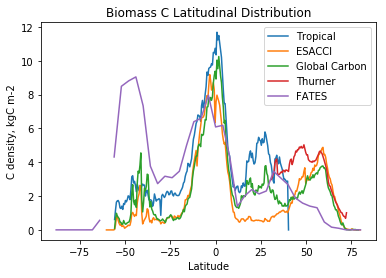

In [54]:
# Define x axis used here
x1 = np.arange(-89.75, 90.25, 0.5)
x2 = np.arange(-60.25, 80.25, 0.5)
x3 = np.arange(-92, 92, 4)
plt.plot(x1, tropical_lat)
plt.plot(x2, esacci_lat*0.1)
plt.plot(x1, gc_lat)
# plt.plot(x1, nbcd2000_lat)
# plt.plot(x1, usf_lat)
plt.plot(x1, thurner_lat)
plt.plot(x3, vegc_all_lat)
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner'])
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner', 'FATES'])
plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'Thurner', 'FATES'])
plt.title('Biomass C Latitudinal Distribution')
plt.xlabel('Latitude')
plt.ylabel('C density, kgC m-2')

Text(0,0.5,'C density, kgC m-2')

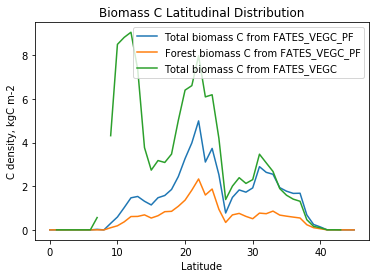

In [60]:
plt.plot(vegc_lat)
plt.plot(vegc_lat_for)
plt.plot(vegc_all_lat)
plt.legend(['Total biomass C from FATES_VEGC_PF', 'Forest biomass C from FATES_VEGC_PF', 'Total biomass C from FATES_VEGC'])
plt.title('Biomass C Latitudinal Distribution')
plt.xlabel('Latitude')
plt.ylabel('C density, kgC m-2')

In [36]:
# Calculate global total
# Check the whole time series 

soilc_copy = copy.deepcopy(soilc[:,:,:])
vegc_copy = copy.deepcopy(vegc[:,:,:])
litterc_copy = copy.deepcopy(litterc[:,:,:])

gpp_copy = copy.deepcopy(gpp[:,:,:])
npp_copy = copy.deepcopy(npp[:,:,:])
hr_copy = copy.deepcopy(hr[:,:,:])
nbp_copy = copy.deepcopy(nbp[:,:,:])
nep_copy = copy.deepcopy(nep[:,:,:])
litc_in_copy = copy.deepcopy(litc_in[:,:,:])
litc_out_copy = copy.deepcopy(litc_out[:,:,:])

tot_len = nyr * 12
tot_soilc = np.zeros((tot_len))
tot_vegc = np.zeros((tot_len))
tot_litterc = np.zeros((tot_len))
tot_gpp = np.zeros((tot_len))
tot_npp = np.zeros((tot_len))
tot_nep = np.zeros((tot_len))
tot_nbp = np.zeros((tot_len))
tot_hr = np.zeros((tot_len))
tot_litc_in = np.zeros((tot_len))
tot_litc_out = np.zeros((tot_len))

for i in np.arange(0, tot_len):
    # Mask can only applied to each 2D slice
    tmp = soilc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_soilc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e15

    tmp = vegc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_vegc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = litterc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litterc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e15
    
    tmp = gpp_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_gpp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = npp_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_npp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = nep_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_nep[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12

    tmp = nbp_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_nbp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e15
    
    tmp = hr_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_hr[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = litc_in_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litc_in[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = litc_out_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litc_out[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    

C:\Users\Jay_S_000\AppData\Local\Temp\ipykernel_3784\2033270784.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tmp[land_4x5<=0] = np.float('nan')
C:\Users\Jay_S_000\AppData\Local\Temp\ipykernel_3784\2033270784.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tmp[tmp>1e10] = np.float('nan')
C:\Users\Jay_S_000\AppData\Local\Temp\i

Text(0, 0.5, 'C Pools (PgC)')

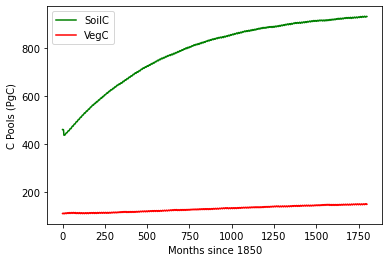

In [24]:
# plt.plot(tot_soilc, 'k-')
plt.plot(tot_vegc, 'g-')
plt.plot(tot_litterc, 'r-')
plt.legend(['SoilC', 'VegC', 'LitterC'])
plt.xlabel('Months since 1850')
plt.ylabel('C Pools (PgC)')

Text(0, 0.5, 'C fluxes (PgC yr-1)')

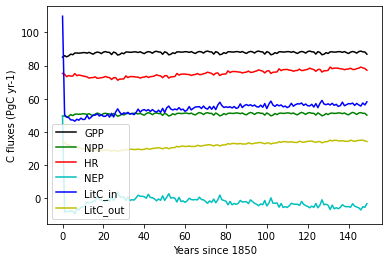

In [43]:
# Calculate annual fluxes
tot_len = nyr * 12
tot_ann_gpp = np.zeros((nyr))
tot_ann_npp = np.zeros((nyr))
tot_ann_hr = np.zeros((nyr))
tot_ann_litc_in = np.zeros((nyr))
tot_ann_litc_out = np.zeros((nyr))
tot_ann_nep = np.zeros((nyr))

for i in np.arange(0, nyr):
    tot_ann_gpp[i] = np.nanmean(tot_gpp[(i*12):((i+1)*12)])
    tot_ann_npp[i] = np.nanmean(tot_npp[(i*12):((i+1)*12)])
    tot_ann_hr[i] = np.nanmean(tot_hr[(i*12):((i+1)*12)])
    tot_ann_litc_in[i] = np.nanmean(tot_litc_in[(i*12):((i+1)*12)])
    tot_ann_litc_out[i] = np.nanmean(tot_litc_out[(i*12):((i+1)*12)])
    tot_ann_nep[i] = np.nanmean(tot_nep[(i*12):((i+1)*12)])

# Check major C fluxes
plt.plot(tot_ann_gpp, 'k-')
plt.plot(tot_ann_npp, 'g-')
plt.plot(tot_ann_hr, 'r-')
plt.plot(tot_ann_nep + (tot_ann_litc_in-tot_ann_litc_out), 'c-')
plt.plot(tot_ann_litc_in, 'b-')
plt.plot(tot_ann_litc_out, 'y-')
plt.legend(['GPP', 'NPP', 'HR', 'NEP', 'LitC_in', 'LitC_out'])
plt.xlabel('Years since 1850')
plt.ylabel('C fluxes (PgC yr-1)')


Text(0,0.5,'C Fluxes (PgC yr-1)')

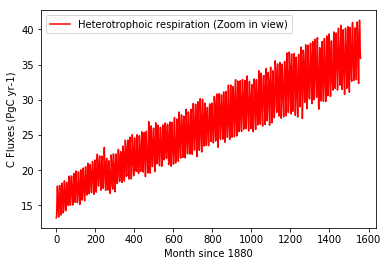

In [66]:
plt.plot(tot_fates_hr, 'r-')
plt.legend(['Heterotrophoic respiration (Zoom in view)'])
plt.xlabel('Month since 1880')
plt.ylabel('C Fluxes (PgC yr-1)')

Text(0, 0.5, 'C Pools (PgC )')

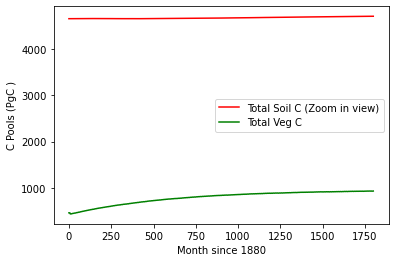

In [11]:
plt.plot(tot_soilc, 'r-')
plt.plot(tot_vegc, 'g-')
plt.legend(['Total Soil C (Zoom in view)', 'Total Veg C'])
plt.xlabel('Month since 1880')
plt.ylabel('C Pools (PgC )')

Text(0,0.5,'C Pools (PgC )')

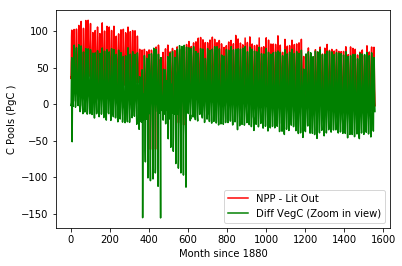

In [81]:
veg_old = tot_vegc[0:tot_len-1]
veg_new = tot_vegc[1:tot_len]
diff_veg = veg_new - veg_old
plt.plot(tot_fates_npp-tot_lit_out, 'r-')
plt.plot(diff_veg*12, 'g-')
plt.legend(['NPP - Lit Out', 'Diff VegC'])
plt.xlabel('Month since 1880')
plt.ylabel('C Pools (PgC )')

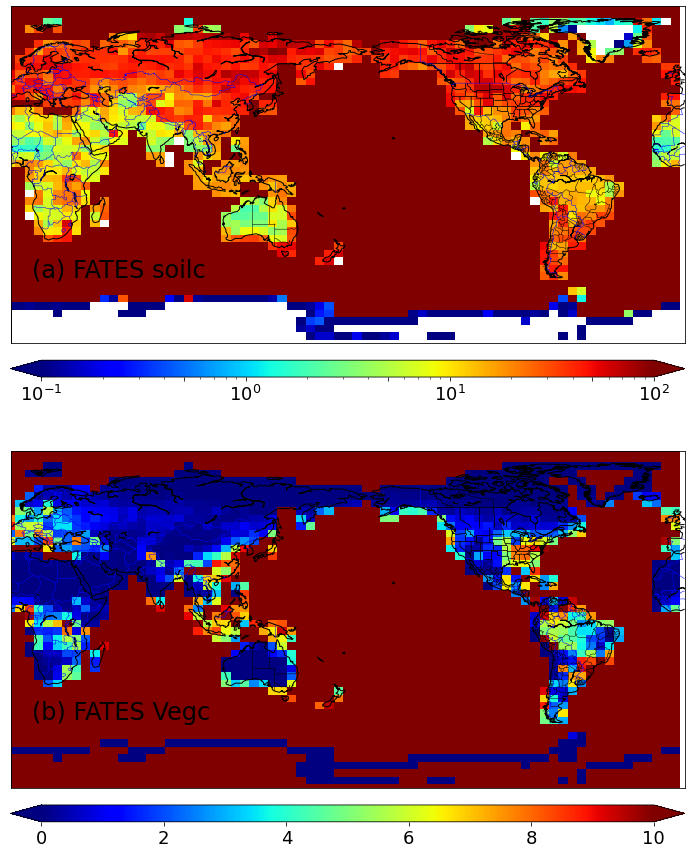

In [8]:
# Plot comparison for secondary area vs. biomass (%)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,soilc[0,:,:]/1e3,
              norm=colors.LogNorm(vmin=1e-1, vmax=1e2),cmap=plt.cm.jet)#cmap=plt.get_cmap('Greens')) # use log color scale,
            # norm=colors.Normalize(vmin=0, vmax=20),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[1e-1, 5e-1, 1, 5, 1e1, 5e1, 1e2],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES soilc', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,vegc[0,:,:],
#              norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=0, vmax=10.0),cmap=plt.cm.jet) # use log color scale

cbar2 = map.colorbar(cs2,ticks=[0, 2, 4, 6, 8, 10],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) FATES Vegc ', fontsize=24)

plt.show()

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in multiply
  app.launch_new_instance()
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in multiply


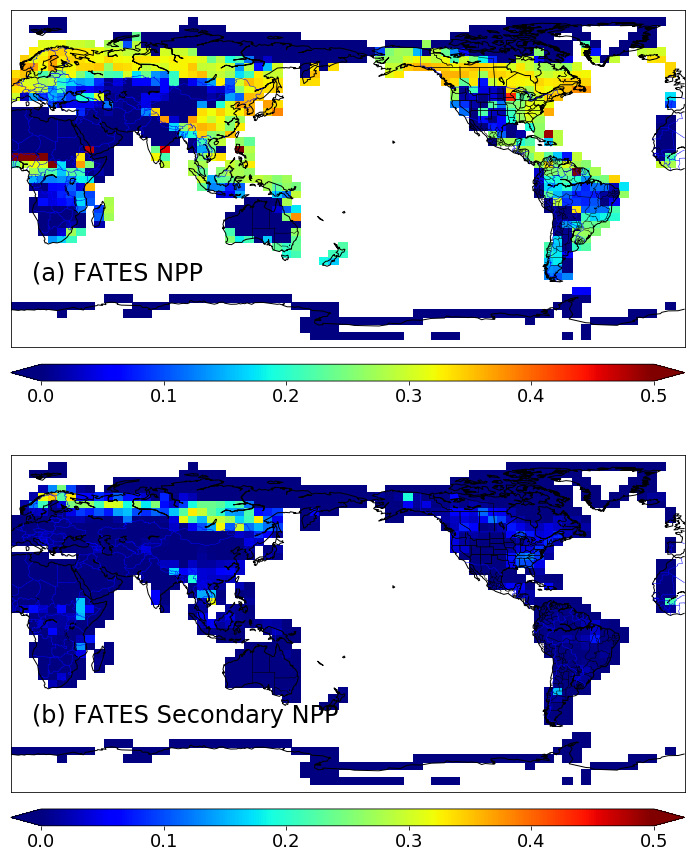

In [13]:
# Plot comparison for total vs. secondary (NPP, kgC m-2 month-1)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,gpp_ts[0,:,:]*3600*24*31,
#               norm=colors.LogNorm(vmin=1e-4, vmax=1e-2),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=0, vmax=0.5),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES NPP', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,gpp_sec[0,:,:]*3600*24*31,
#              norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=0, vmax=0.5),cmap=plt.cm.jet) # use log color scale

cbar2 = map.colorbar(cs2,ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) FATES Secondary NPP', fontsize=24)

plt.show()

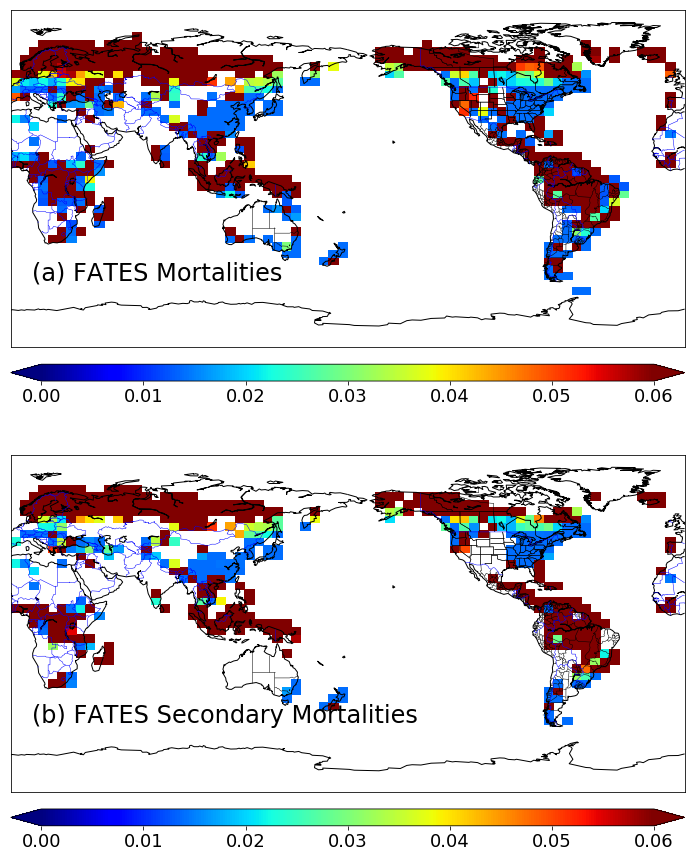

In [36]:
# Plot comparison for total vs. secondary (Mortality rate, % of plant numbers, based on year-1)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,rmort_tot[:,:],
#               norm=colors.LogNorm(vmin=1e-4, vmax=1e-2),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=0, vmax=0.06),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES Mortalities', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,rmort_sec[:,:],
#              norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=0, vmax=0.06),cmap=plt.cm.jet) # use log color scale

cbar2 = map.colorbar(cs2,ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) FATES Secondary Mortalities', fontsize=24)

plt.show()


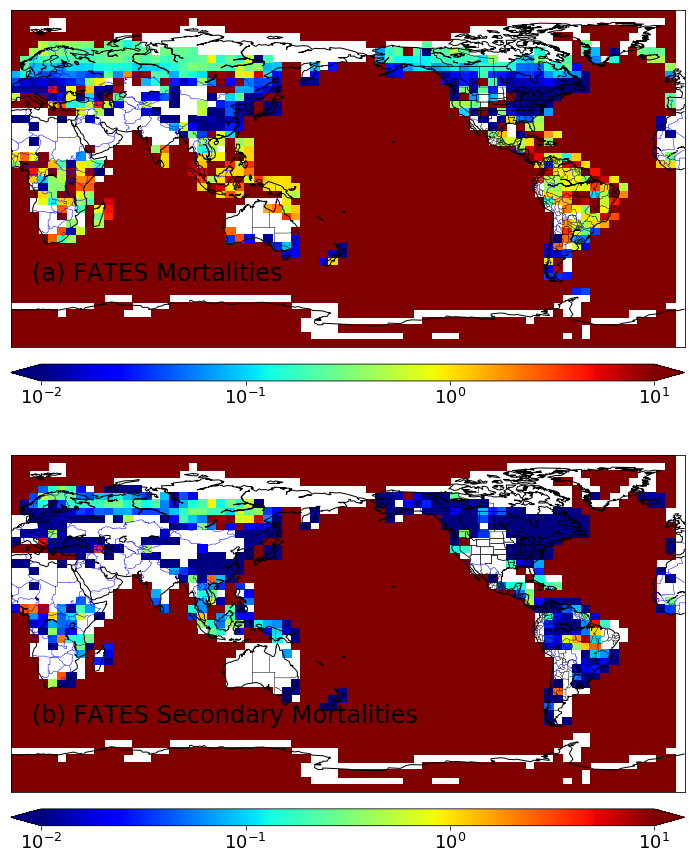

In [39]:
# Plot comparison for total vs. secondary (Mortality, plant numbers year-1)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,mort_tot[:,:],
              norm=colors.LogNorm(vmin=1e-2, vmax=1e1),cmap=plt.cm.jet) # use log color scale,
#             norm=colors.Normalize(vmin=0, vmax=0.06),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[1e-2, 1e-1, 1, 1e1],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES Mortalities', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,mort_sec[:,:],
             norm=colors.LogNorm(vmin=1e-2, vmax=1e1),cmap=plt.cm.jet) # use log color scale,
#             norm=colors.Normalize(vmin=0, vmax=0.06),cmap=plt.cm.jet) # use log color scale

cbar2 = map.colorbar(cs2,ticks=[1e-2, 1e-1, 1, 1e1],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) FATES Secondary Mortalities', fontsize=24)

plt.show()

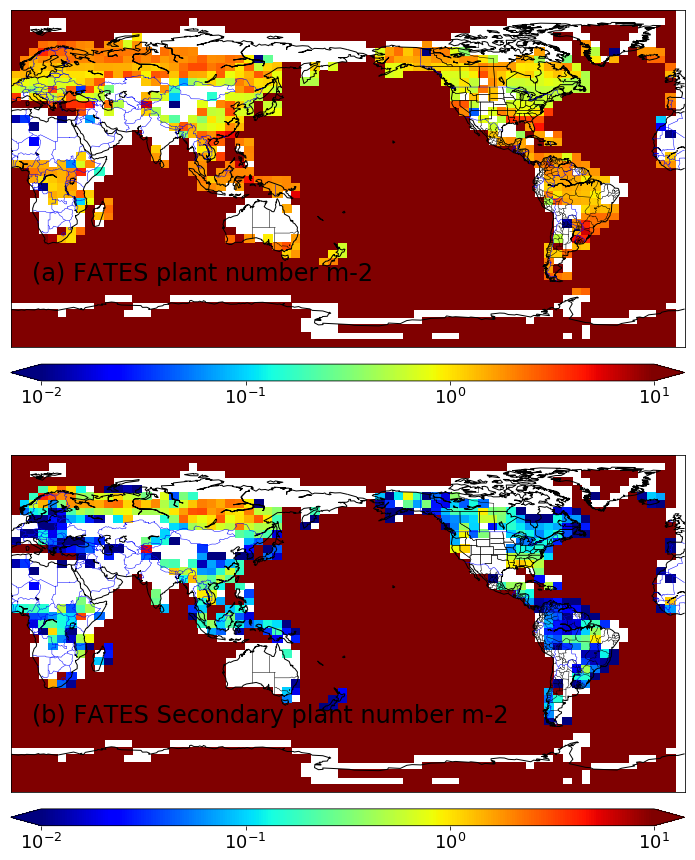

In [30]:
# Plot comparison for total vs. secondary (Number of plants, #, based on year-1)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,forest_tot[:,:],
              norm=colors.LogNorm(vmin=1e-2, vmax=1e1),cmap=plt.cm.jet) # use log color scale,
#             norm=colors.Normalize(vmin=0, vmax=200),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[1e-2, 1e-1, 1, 1e1],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES plant number m-2', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,forest_sec[:,:],
             norm=colors.LogNorm(vmin=1e-2, vmax=1e1),cmap=plt.cm.jet) # use log color scale,
#             norm=colors.Normalize(vmin=0, vmax=200),cmap=plt.cm.jet) # use log color scale

cbar2 = map.colorbar(cs2,ticks=[1e-2, 1e-1, 1, 1e1],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) FATES Secondary plant number m-2', fontsize=24)

plt.show()

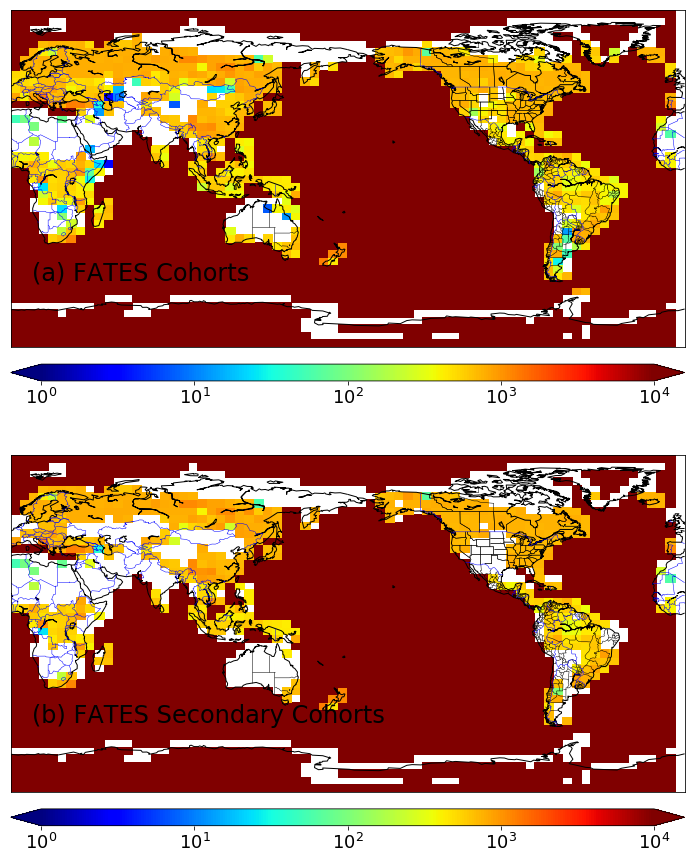

In [16]:
# Plot comparison for total vs. secondary (Number of cohorts, #, based on year-1)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,ncohorts[0,:,:],
              norm=colors.LogNorm(vmin=1, vmax=1e4),cmap=plt.cm.jet) # use log color scale,
#             norm=colors.Normalize(vmin=0, vmax=200),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[1, 1e1, 1e2, 1e3, 1e4],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES Cohorts', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,ncohorts_sec[0,:,:],
             norm=colors.LogNorm(vmin=1, vmax=1e4),cmap=plt.cm.jet) # use log color scale,
#             norm=colors.Normalize(vmin=0, vmax=200),cmap=plt.cm.jet) # use log color scale

cbar2 = map.colorbar(cs2,ticks=[1, 1e1, 1e2, 1e3, 1e4],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) FATES Secondary Cohorts', fontsize=24)

plt.show()

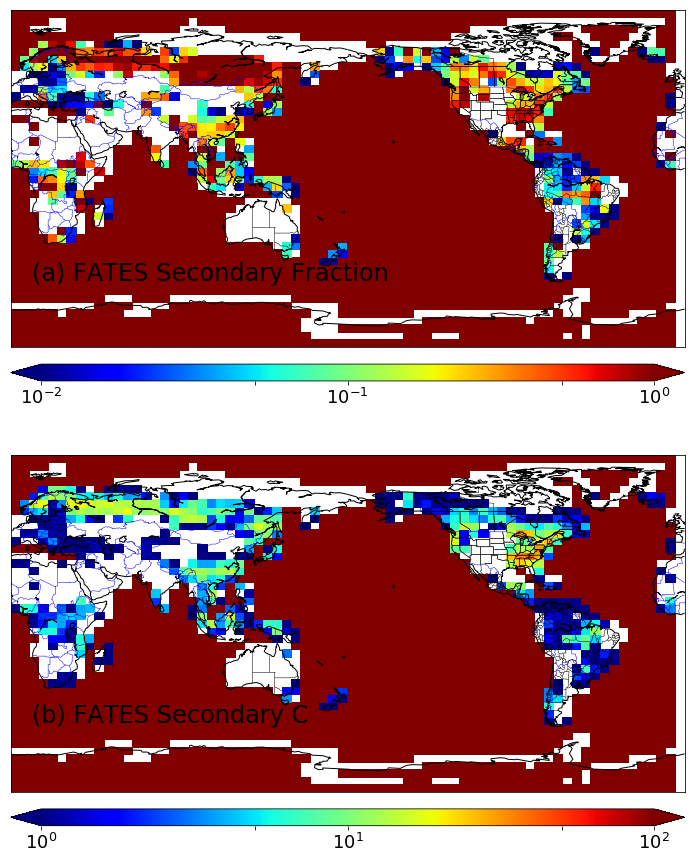

In [27]:
# Secondary forest area map (in fraction)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,sec_frac[1919,:,:],
#               norm=colors.LogNorm(vmin=1e-4, vmax=1e-2),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.LogNorm(vmin=1e-2, vmax=1),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[1e-2, 5e-2, 1e-1, 5e-1, 1],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES Secondary Fraction', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,sec_biomass[1919,:,:],
#              norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.LogNorm(vmin=1, vmax=100),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[1, 5, 10, 50, 100],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) FATES Secondary C', fontsize=24)

plt.show()
# plt.savefig('FATES_SEC.jpg',dpi=300)

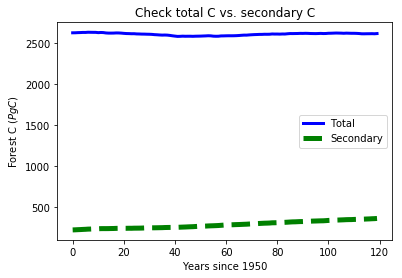

In [10]:
# Line plot secondary C vs. total C
biomass_day = copy.deepcopy(biomass_ts)
biomass_sec_day = copy.deepcopy(sec_biomass)

# Clear data with ocean mask
biomass_day[biomass_day>1e4] = np.float('nan')
biomass_sec_day[biomass_sec_day>1e4] = np.float('nan')

# New vars
biomass_yr = np.ones([nyr, 46, 72])*np.float('nan')
biomass_yr_sec = np.ones([nyr, 46, 72])*np.float('nan')
delta_biomass_sec = np.ones([nyr-1, 46, 72])*np.float('nan')

for iyr in np.arange(0,nyr):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    biomass_yr[iyr,:,:] = np.nanmean(biomass_day[id_beg:id_end,:,:])*area_4x5*nat_area_frac[0,:,:]*1e6
    biomass_yr_sec[iyr,:,:] = np.nanmean(biomass_sec_day[id_beg:id_end,:,:])*area_4x5*nat_area_frac[0,:,:]*1e6
    if(iyr > 0):
        delta_biomass_sec[iyr-1,:,:] = biomass_yr_sec[iyr,:,:] - biomass_yr_sec[iyr-1,:,:]

biomass_yr_tot = np.nansum(np.nansum(biomass_yr, 2), 1)/1e12
biomass_sec_yr_tot = np.nansum(np.nansum(biomass_yr_sec, 2), 1)/1e12
plt.plot(biomass_yr_tot, 'b-', linewidth=3)
plt.plot(biomass_sec_yr_tot, 'g--', linewidth=5)
plt.xlabel('Years since 1950')
plt.ylabel('Forest C ($PgC$)')
plt.legend(['Total', 'Secondary'])
plt.title('Check total C vs. secondary C')
plt.show()
# plt.savefig('validate_luc_frac_global.png')



In [11]:
biomass_yr_tot

array([2623.68099719, 2624.09762058, 2625.79019745, 2626.669578  ,
       2628.28976035, 2628.04046058, 2630.52440896, 2629.80614173,
       2629.3052355 , 2629.13454056, 2625.69313911, 2627.69534452,
       2626.38887178, 2621.89881435, 2620.02365423, 2619.91701425,
       2620.27987406, 2622.09736698, 2621.70522997, 2619.8392966 ,
       2616.90891532, 2614.66308813, 2613.93452952, 2612.43464983,
       2612.7018708 , 2610.05876092, 2609.37633607, 2607.95506122,
       2607.61296161, 2606.46227904, 2605.79227481, 2604.33852889,
       2601.20001335, 2599.6261422 , 2597.29532243, 2595.56779036,
       2596.56658638, 2595.34368672, 2591.81232442, 2587.21828858,
       2583.3038386 , 2579.75881361, 2580.68486023, 2582.61396137,
       2581.34102432, 2581.73954908, 2581.85222193, 2580.68716692,
       2582.11234539, 2582.70818071, 2583.373749  , 2584.68164124,
       2585.86994057, 2587.7772169 , 2586.5626568 , 2582.59124936,
       2581.43435648, 2581.9432474 , 2585.65737038, 2586.06352

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
C:\Users\sshu3\Anaconda2\lib\site-packages\matplotlib\colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


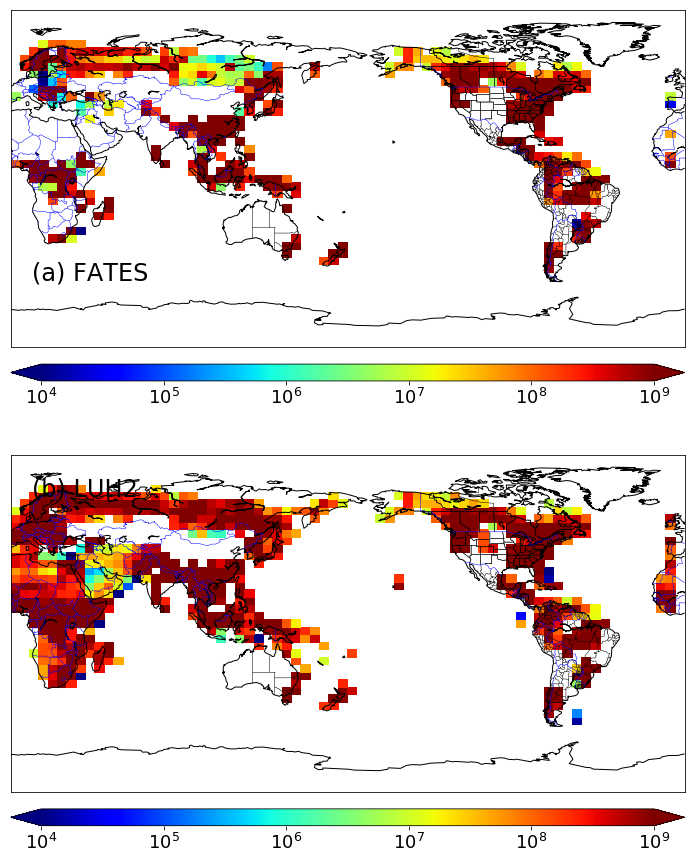

In [12]:
# Mask ocean
fates_hrv_c[fates_hrv_c>1e4] = np.float('nan')

# Secondary forest area map (in KgC)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,fates_hrv_c[1919,:,:]*1e-3*area_4x5*1e6*3600*24*365,
#               norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[1e4, 1e5, 1e6, 1e7, 1e8, 1e9],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,lu_hrv_c[159,:,:],
#              norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[1e4, 1e5, 1e6, 1e7, 1e8, 1e9],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.43, '(b) LUH2', fontsize=24)

plt.show()
# plt.savefig('PRIM_HARV.jpg',dpi=300)

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


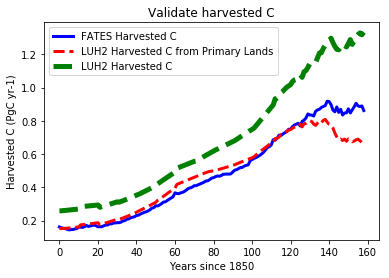

In [33]:
# Check the total harvested C.
## Validate harvested C (gC m-2 yr-1). 
lu_hrv_c_tot = copy.deepcopy(lu_hrv_c)
lu_hrv_prim_c_tot = copy.deepcopy(lu_hrv_c-lu_hrv_c_sec)
fates_hrv_c_tot = np.zeros((nyr, 46, 72))

# Apply Mask 
# No cohorts
fates_hrv_c[fates_hrv_c>1] = np.float('nan')

for iyr in np.arange(0,nyr-1):
    # Middle of year
    id_beg = iyr*12+1
    # gC m-2 s-1 -> kg C
    fates_hrv_c_tot[iyr, :, :] = fates_hrv_c[id_beg,:,:]*1e-3*area_4x5*1e6*3600*24*365
    
hrv_c_luh2_yr_tot = np.nansum(np.nansum(lu_hrv_c_tot, 2), 1)/1e12
hrv_c_luh2_prim_yr_tot = np.nansum(np.nansum(lu_hrv_prim_c_tot, 2), 1)/1e12
hrv_c_fates_yr_tot = np.nansum(np.nansum(fates_hrv_c_tot, 2), 1)/1e12

plt.plot(hrv_c_fates_yr_tot[0:159], 'b-', linewidth=3)
plt.plot(hrv_c_luh2_prim_yr_tot[0:159], 'r--', linewidth=3)
plt.plot(hrv_c_luh2_yr_tot[0:159], 'g--', linewidth=5)
plt.xlabel('Years since 1850')
plt.ylabel('Harvested C (PgC yr-1)')
# plt.ylim([0, 0.8])
plt.legend(['FATES Harvested C', 'LUH2 Harvested C from Primary Lands', 'LUH2 Harvested C'])
plt.title('Validate harvested C')
plt.show()
# plt.savefig('validate_hrv_c_global.png')


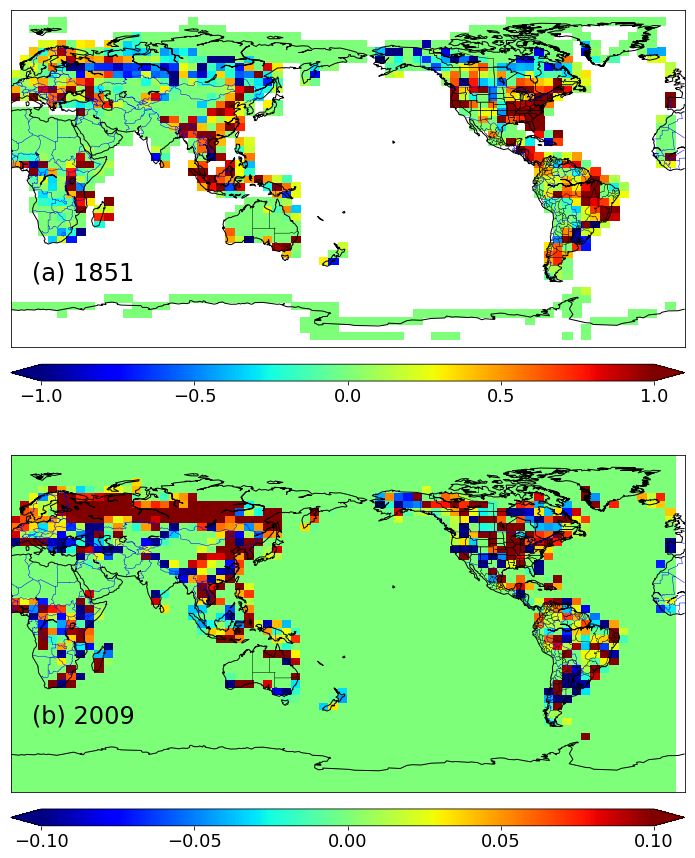

In [20]:
## Check VegC change for every year
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,delta_biomass[0,:,:],
#               norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=-1, vmax=1),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[-1, -0.5, 0, 0.50, 1],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) 1851', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,delta_biomass[158,:,:],
#              norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=-0.1, vmax=0.1),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[-0.1, -0.05, 0, 0.05, 0.1],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) 2009', fontsize=24)

plt.show()
# plt.savefig('DvegC.jpg',dpi=300)


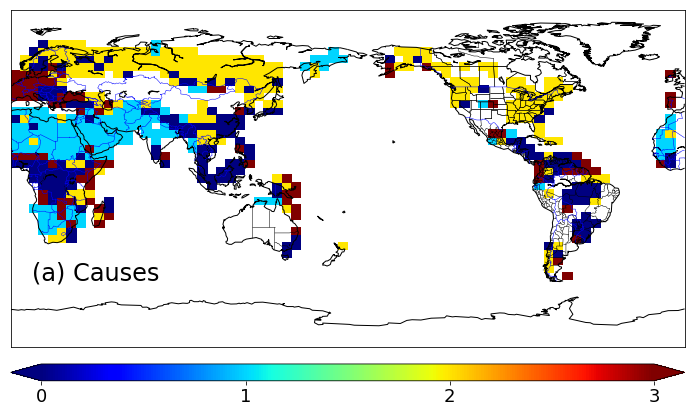

In [22]:
## Map to show what type of issue each gridcell has when logging is introduced.
# Check the total harvested C.
## Validate harvested C (gC m-2 yr-1). 
# reason_map = np.ones((46, 72))*np.float('nan')
biomass_init = biomass_ts[0,:,:]
ch_biomass = delta_biomass[58,:,:]*sec_frac[1919,:,:]*area_4x5*1e6
ch_hrv_debt_sec = hrv_debt_sec[1919,:,:] - hrv_debt_sec[1919,:,:]
hrv_req = lu_hrv_c_sec[160,:,:]
mature_area = area_age[1919, 6, :, :]
secbiomass_minus_hrv = sec_biomass[1919,:,:]*area_4x5*1e6 - lu_hrv_c_sh1[160,:,:] - lu_hrv_c_sh3[160,:,:]
ch_minus_req = ch_biomass*area_4x5*1e6 - ch_hrv_debt_sec
debt_mask = copy.deepcopy(hrv_debt_sec[1919,:,:])
debt_mask[debt_mask>1e15] = -9999.
sec_frac_mask = copy.deepcopy(sec_frac[1919,:,:])

# Apply Mask
# 0. Secondary forest did not reach maturity
reason_map = np.zeros((46, 72))

# 2. Low growth rate 
# Change of secondary biomass lower than the harvest rate
reason_map[ch_minus_req<0] = 2
# reason_map[secbiomass_minus_hrv>0] = 0

# 3. Too tiny secondary forest area (<1% of gridcell)
reason_map[sec_frac_mask<0.01] = 3

# 1. No cohorts survived
# Zero biomass grids with secondary forest harvest debt
reason_map[biomass_init==0] = 1

# Mask out area with no secondary forest harvest debt
reason_map[debt_mask<=0] = np.float('nan')


lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,reason_map,
#               norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=0, vmax=3),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[0, 1, 2, 3],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) Causes', fontsize=24)

# for iyr in np.arange(0,nyr-1):
#     # Middle of year
#     id_beg = iyr*12+1
#     # gC m-2 s-1 -> kg C
#     fates_hrv_c_tot[iyr, :, :] = fates_hrv_c[id_beg,:,:]*1e-3*area_4x5*1e6*3600*24*365
    
# hrv_c_luh2_yr_tot = np.nansum(np.nansum(lu_hrv_c_tot, 2), 1)/1e12
# hrv_c_fates_yr_tot = np.nansum(np.nansum(fates_hrv_c_tot, 2), 1)/1e12

# plt.plot(hrv_c_fates_yr_tot, 'b-', linewidth=3)
# plt.plot(hrv_c_luh2_yr_tot[0:40], 'g--', linewidth=5)
# plt.xlabel('Years since 1850')
# plt.ylabel('Harvested C (PgC yr-1)')
# plt.ylabel('Harvested C (PgC yr-1)')
# # plt.ylim([0, 0.8])
# plt.legend(['FATES Harvested C', 'LUH2 Harvested C'])
# plt.title('Validate harvested C')
plt.show()
# plt.savefig('causes.png')


In [21]:
np.shape(area_age)

(1920L, 7L, 46L, 72L)

In [ ]:
21912-365

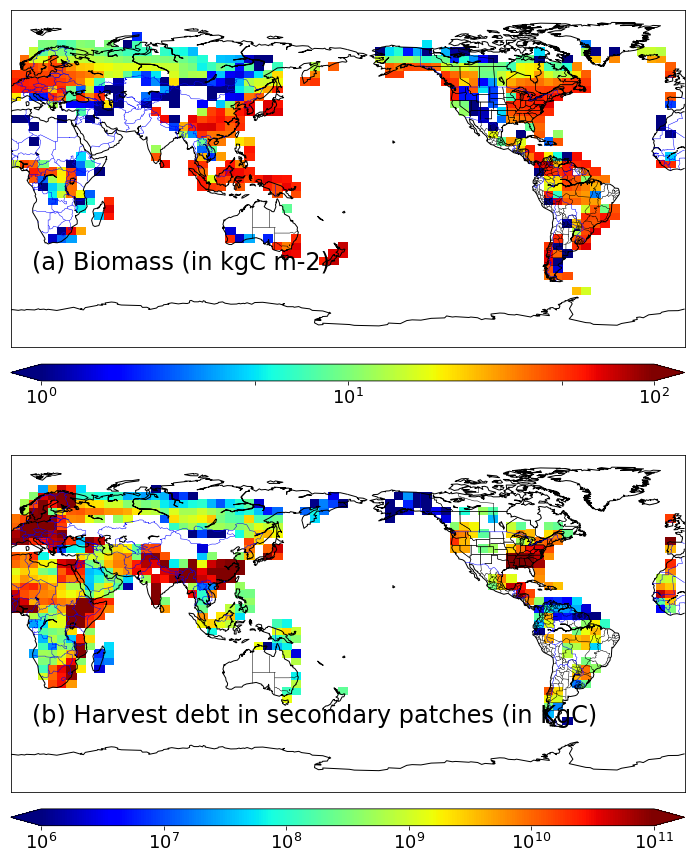

In [24]:
hrv_debt_sec_cp = copy.deepcopy(hrv_debt_sec)
hrv_debt_sec_cp[hrv_debt_sec_cp>1e15] = np.float('nan')

# Biomass map
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,biomass_den[:,:],
              norm=colors.LogNorm(vmin=1, vmax=1e2),cmap=plt.cm.jet) # use log color scale,
cbar = map.colorbar(cs1,ticks=[1, 5, 10, 50, 100],location='bottom',pad="5%",extend='both')

# cs1 = map.pcolormesh(x,y,hrv_debt_sec[100,:,:],
#               norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.cm.jet) # use log color scale,
# cbar = map.colorbar(cs1,ticks=[1e4, 1e5, 1e6, 1e7, 1e8, 1e9],location='bottom',pad="5%",extend='both')

# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.64, '(a) Biomass (in kgC m-2)', fontsize=24)

# Harvest debt map
ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,hrv_debt_sec_cp[1919,:,:],
              norm=colors.LogNorm(vmin=1e6, vmax=1e11),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[1e6, 1e7, 1e8, 1e9, 1e10, 1e11],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) Harvest debt in secondary patches (in KgC)', fontsize=24)

plt.show()
# plt.savefig('FATES_biomass_hrvdebt_global_map.png')

In [ ]:
np.shape(biomass_den)

IndexError: too many indices for array

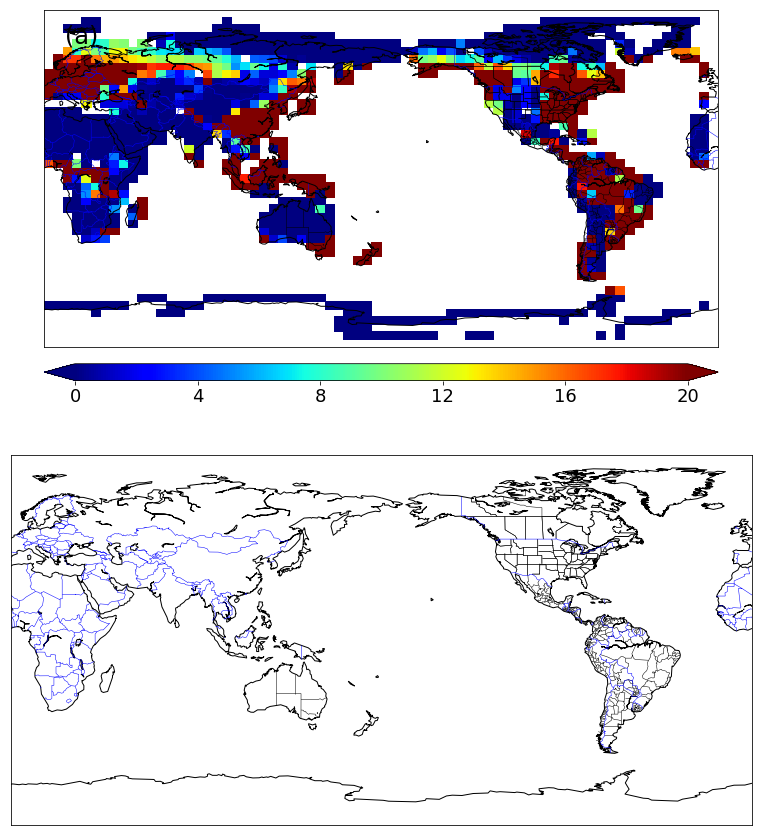

In [25]:
# Biomass plot
# Secondary forest area map
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,biomass_den[:,:],
              norm=colors.Normalize(vmin=0, vmax=20),cmap=plt.cm.jet) # use log color scale,

cbar = map.colorbar(cs1,ticks=[0, 4, 8, 12, 16, 20],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.85, '(a)', fontsize=24)

## Biomass den from LUH2?
ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,biomass_den[3650,:,:]-biomass_den[0,:,:],
              norm=colors.Normalize(vmin=-1, vmax=1),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.43, '(b)', fontsize=24)

plt.show()
# plt.savefig('SEC_FRAC.jpg',dpi=300)



In [ ]:
############################################################
### WARNING: THIS CALCULATION CONSUME MUCH TIME
### DON'T RUN IT UNLESS YOU REALLY NEED RESULTS
### Check the output biomass data from FATES
### Dominant PFTs, number of PFTs from the surface data
############################################################
filename_in = 'extracted_chrv_1850s.nc'

fin = nc.netcdf_file(filename_in)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years
patch_age_bins = fin.variables['fates_levage'][:]

## define the sizes of each dimension
ntim = len(time)
nagebins = len(patch_age_bins)

## read in variables
sec_frac = fin.variables['FATES_SECONDARY_FOREST_FRACTION'][:]
biomass_age = fin.variables['FATES_VEGC_SZPF'][:]
area_age = fin.variables['FATES_PATCHAREA_AP'][:]
hrv_debt = fin.variables['HARVEST_DEBT'][:]
hrv_debt_sec = fin.variables['HARVEST_DEBT_SEC'][:]
hrv_flux10c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD10C'][:]
hrv_flux100c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD100C'][:]
# landfrac = fin.variables['landfrac'][:]

fin.close()

### Any biomass value higher than 0.01 shall be accounted
biomass_myr = np.nanmean(biomass_age, 0)
# biomass is in the dimension of size*pft
biomass_pft = np.zeros((12,46,72))
for i in np.arange(0,12):
    biomass_pft[i,:,:] = np.nansum(biomass_myr[(i-1)*13:i*13,:,:], 0)

numpft_fates = np.zeros((46,72))
dompft_fates = np.zeros((46,72))
## Calculate numbers of PFTs
for i in np.arange(0,72):
    for j in np.arange(0,46):
        dominant_k = 1
        for k in np.arange(1,12):
            if(biomass_pft[k,j,i] > 0.0):
                numpft_fates[j,i] = numpft_fates[j,i] + 1
            if(biomass_pft[k,j,i]>biomass_pft[dominant_k,j,i]):
                dominant_k = k
                dompft_fates[j,i] = k

### Plot to show number of PFTs and the dominant PFT
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,numpft_fates[:,:],
              norm=colors.Normalize(vmin=0, vmax=5),cmap=plt.cm.jet) # use log color scale,

cbar = map.colorbar(cs1,ticks=[0, 1, 2, 3, 4, 5],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.64, '(a) Number of PFTs - FATES', fontsize=24, color='White')

# Harvest debt map
ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,dompft_fates[:,:],
              norm=colors.Normalize(vmin=0, vmax=6),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[0, 1, 2, 3, 4, 5, 6],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) Dominant PFT - FATES', fontsize=24, color='White')

# plt.show()
plt.savefig('fates_fixed_biogeog_map_global_4x5.png')